In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, RegexpTokenizer, TweetTokenizer 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import string
import re

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stopwords = stopwords.words('english')
#from src.confusion import plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brettzimmerman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('phase-4-dataset.csv', encoding= 'latin1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


# Data Cleaning

In [3]:
df = df.dropna(axis=0, subset=['tweet_text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


Renaming Columns

In [4]:
new_stopwords = ["sxsw", "android", "google", "apple", "ipad", "app", "austin", 'iphone']
punctuations = string.punctuation
stopwords.extend(new_stopwords)
stopwords.extend(punctuations)

In [5]:
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product" : "emotion"}, inplace=True)
df.rename(columns={"emotion_in_tweet_is_directed_at" : "product"}, inplace=True)


Adding a label encoder to our target column

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['emotion'])
df['label'] = le.transform(df['emotion'])
df.head()

,tweet_text,product,emotion,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3


In [7]:
df['label'].value_counts(normalize=True)

2    0.592609
3    0.327541
1    0.062692
0    0.017158
Name: label, dtype: float64

Seeing how many labels we're working with here

In [8]:
df.drop(df[df['label']==0].index, inplace = True)

In [9]:
df['label'].value_counts(normalize=True)

2    0.602954
3    0.333259
1    0.063787
Name: label, dtype: float64

## Functions For Text Preprocessing

In [10]:
#Create a function to clean the Tweets
def remove_junk(text):
    text = re.sub(r'@[A-Za-z0-9#]+', '', str(text)) #remove @mentions 
    text = re.sub(r'RT[\s]+', '', str(text)) # remove RT
    text = re.sub(r'\[VIDEO\]', '', str(text)) # remove [VIDEO] describer
    text = re.sub(r'\{link\}', '', str(text)) # remove {link} describer
    text = re.sub(r'https?:\/\/\S+', '', text) # removes actual links
    text = re.sub(r'#', '', str(text)) # remove hashtag symbol
    text = re.sub(r'&quot', '', str(text)) # remove weird quote symbol
    text = re.sub(r'&amp', '', str(text)) # remove weird and symbol
    #text = re.sub(r'[^A-Za-z0-9#]', '', str(text)) # remove weird and symbol
    #text = re.sub(r'[\,\.\?\*\$\'\"\!\(\)\:\_\/\-\=\^\;]+', '', text)
    return text

#ADD PROPER NOUNS TO STOPWORDS

In [11]:
df['model_text'] = df['tweet_text'].apply(remove_junk)

In [12]:
df.head()

,tweet_text,product,emotion,label,model_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1,. I have a 3G iPhone. After 3 hrs tweeting at ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3,Know about ? Awesome iPad/iPhone app that yo...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3,Can not wait for iPad 2 also. They should sal...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1,I hope this year's festival isn't as crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3,great stuff on Fri SXSW: Marissa Mayer (Googl...


In [13]:
#Create a function that tokenizes text
def tokenize(text):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokenized_tweet = regex_token.tokenize(text)
    tweet_tokens = [word.lower() for word in tokenized_tweet]
    #cleaned_tweet = [word for word in lowered_tokens if word not in sw]
    return tweet_tokens

In [14]:
#Create a function that removes stopwords and punctuation 
#punctuations = string.punctuation

def remove_sw_punct(tweet_tokens):
    tweets_clean = [word for word in tweet_tokens if word not in stopwords]
    return tweets_clean

In [16]:
stemmer = PorterStemmer()

def stemming(tweets_clean):
    tweets_stem = [stemmer.stem(token) for token in tweets_clean]         
    return tweets_stem

In [70]:
#Combining the preprocessing into a function
def process_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = tokenize(processed_tweet)
    tweets_clean = remove_sw_punct(tweet_tokens)
    tweets_stem = stemming(tweets_clean)
    return tweets_stem

In [71]:
#pop 'can't' from stopwords
tweet_example = df['tweet_text'][0]
print(tweet_example)

processed_tweet = process_tweet(tweet_example)
print(processed_tweet)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
['g', 'hr', 'tweet', 'rise', 'dead', 'need', 'upgrad', 'plugin', 'station']


In [ ]:
tweets_machine = ' '.join(tweets_stem)

In [72]:
df['processed_tweet'] = [process_tweet(i) for i in df['tweet_text']]
df['machine_tweet'] = [' '.join(i) for i in df['processed_tweet']]

In [73]:
df

,tweet_text,product,emotion,label,model_text,processed_tweet,machine_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1,. I have a 3G iPhone. After 3 hrs tweeting at ...,"[g, hr, tweet, rise, dead, need, upgrad, plugi...",g hr tweet rise dead need upgrad plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3,Know about ? Awesome iPad/iPhone app that yo...,"[know, awesom, like, appreci, design, also, gi...",know awesom like appreci design also give free ts
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3,Can not wait for iPad 2 also. They should sal...,"[wait, also, sale]",wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1,I hope this year's festival isn't as crashy a...,"[hope, year, festiv, crashi, year]",hope year festiv crashi year
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3,great stuff on Fri SXSW: Marissa Mayer (Googl...,"[great, stuff, fri, marissa, mayer, tim, reill...",great stuff fri marissa mayer tim reilli tech ...
...,...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,3,Ipad everywhere. SXSW,[everywher],everywher
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,2,"Wave, buzz... We interrupt your regularly sche...","[wave, buzz, interrupt, regularli, schedul, ge...",wave buzz interrupt regularli schedul geek pro...
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,2,"Google's Zeiger, a physician never reported po...","[zeiger, physician, never, report, potenti, ae...",zeiger physician never report potenti ae yet f...
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,2,Some Verizon iPhone customers complained their...,"[verizon, custom, complain, time, fell, back, ...",verizon custom complain time fell back hour we...


In [20]:
nltk.pos_tag(processed_tweet)

[('g', 'NN'),
 ('hrs', 'NN'),
 ('tweeting', 'VBG'),
 ('rise', 'NN'),
 ('dead', 'JJ'),
 ('need', 'NN'),
 ('upgrade', 'JJ'),
 ('plugin', 'NN'),
 ('stations', 'NNS')]

In [21]:
df.loc[11]


tweet_text         Find &amp; Start Impromptu Parties at #SXSW Wi...
product                                                  Android App
emotion                                             Positive emotion
label                                                              3
model_text         Find ; Start Impromptu Parties at SXSW With   ...
processed_tweet    [find, start, impromptu, parties, wait, til, c...
Name: 11, dtype: object

In [22]:
data_neg = df['processed_tweet'].loc[df['label'] == 1]

negative_sentiment = []
for i in data_neg:
    listToStr = ' '.join(map(str, i))
    negative_sentiment.append(listToStr)
negative_sentiment = ' '.join(map(str,  negative_sentiment))


In [23]:
data_pos = df['processed_tweet'].loc[df['label'] == 3]

positive_sentiment = []
for i in data_pos:
    listToStr = ' '.join(map(str, i))
    positive_sentiment.append(listToStr)
positive_sentiment = ' '.join(map(str,  positive_sentiment))

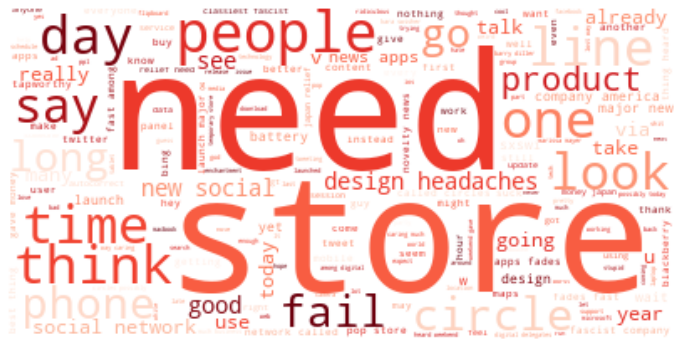

In [55]:
from wordcloud import WordCloud
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data

# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='Reds'
)
# generate the word cloud
wc.generate(negative_sentiment)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

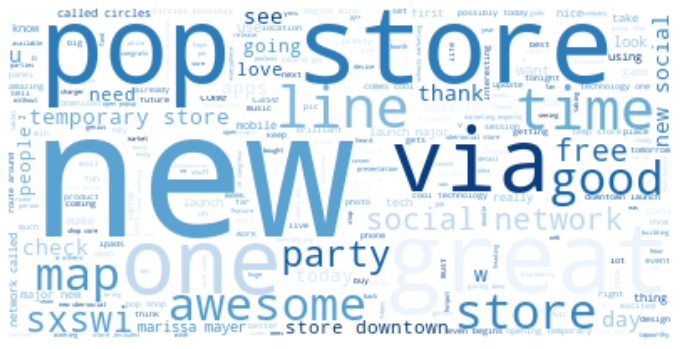

In [53]:
from wordcloud import WordCloud
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data

# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='Blues'
)
# generate the word cloud
wc.generate(positive_sentiment)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
from nltk import FreqDist

example_freq_dist = FreqDist(X_train.iloc[100]["processed_tweet"][:20])
example_freq_dist

FreqDist({'going': 1, 'check': 1, 'pop': 1, 'shop': 1, 'sxswi': 1, 'let': 1, 'us': 1, 'know': 1})

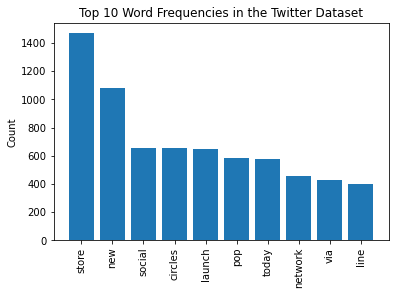

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
train_freq_dist = FreqDist(df['processed_tweet'].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequencies in the Twitter Dataset")

# Train Test Split

In [74]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = .9)

# Baseline Model Using a Dummy Classifier

In [27]:
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline

dum_pipe = Pipeline([('count', CountVectorizer()),
                    ('model', DummyClassifier(strategy='stratified'))])

model = dum_pipe.fit(X_train['model_text'], y_train)

y_trn_pred = dum_pipe.predict(X_train['model_text'])
y_tst_pred = dum_pipe.predict(X_test['model_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           1       0.06      0.06      0.06       513
           2       0.61      0.61      0.61      4849
           3       0.34      0.34      0.34      2680

    accuracy                           0.49      8042
   macro avg       0.34      0.34      0.34      8042
weighted avg       0.49      0.49      0.49      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.05      0.05      0.05        57
           2       0.62      0.62      0.62       539
           3       0.34      0.34      0.34       298

    accuracy                           0.49       894
   macro avg       0.34      0.34      0.34       894
weighted avg       0.49      0.49      0.49       894



# Grid Search on Multinomial NB

In [81]:

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

tf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize)),
    ('smt', SMOTE(random_state=30)),
    ('mnb', MultinomialNB()),
])
parameters = {
    'tfidf__max_df': (0.25, 0.75, 0.90),
    'tfidf__min_df': (2, 3),
    'tfidf__ngram_range': [(1,1),(1, 2), (1, 3)],
    'tfidf__max_features': (10000, 70000, 85000),
    'tfidf__norm': ('l1', 'l2'),
    'mnb__alpha': (.005, .05, .5),
    'smt__k_neighbors' : (2,5)
    
}

grid_search = GridSearchCV(tf_nb_pipe, parameters, cv=2, n_jobs=2, verbose=3, scoring = f1_macro)
grid_search.fit(X_train['tweet_text'], y_train)

tf_nb_best = grid_search.best_estimator_

y_trn_pred = tf_nb_best.predict(X_train['tweet_text'])
y_tst_pred = tf_nb_best.predict(X_test['tweet_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

Fitting 2 folds for each of 648 candidates, totalling 1296 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   22.1s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:   51.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 1296 out of 1296 | elapsed:  4.7min finished


		The Train Results
              precision    recall  f1-score   support

           1       0.66      0.97      0.78       513
           2       0.92      0.84      0.87      4849
           3       0.79      0.84      0.81      2680

    accuracy                           0.85      8042
   macro avg       0.79      0.88      0.82      8042
weighted avg       0.86      0.85      0.85      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.34      0.47      0.39        57
           2       0.77      0.70      0.73       539
           3       0.56      0.61      0.59       298

    accuracy                           0.65       894
   macro avg       0.56      0.59      0.57       894
weighted avg       0.67      0.65      0.66       894



In [82]:
tf_nb_best

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, max_features=10000, min_df=2,
                                 ngram_range=(1, 2), norm='l1',
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenize at 0x15813c8b0>)),
                ('smt', SMOTE(k_neighbors=2, random_state=30)),
                ('mnb', MultinomialNB(alpha=0.005))])

In [49]:
def predict(pipeline, text):
    # Predict the sentiment
    #textdata = pipeline.transform()
    text = [remove_junk(i) for i in text]
    sentiment = pipeline.predict(text)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([1,2,3], ['Negative', 'Neutral', 'Positive'])
    return df

In [51]:
tweets = ["I hate Apple", "My stupid ipad broke after one use", "I heard Nate Walter is giving a speech. love that guy"]
tweets
predictions = predict(tf_nb_best, tweets)
print(predictions.head())

                                                text sentiment
0                                       I hate Apple  Negative
1                 My stupid ipad broke after one use  Negative
2  I heard Nate Walter is giving a speech. love t...  Positive


In [56]:
grid_search.multimetric_

False

### Now to remove all of those @mentions

In [46]:
#X_train['clean_tweet'] = X_train['tweet_text'].apply(remove_junk)
#X_train['clean_tweet'] = X_train['clean_tweet'].apply(remove_nonASCII)
#X_train["clean_tokens"] = X_train["clean_tweet"].apply(tokenize_sw)

In [47]:
#X_train["tweet_text"] = X_train["tweet_text"].str.lower()
#basic_token_pattern = r"(?u)\b\w\w+\b"

#tokenizer = RegexpTokenizer(basic_token_pattern)
#X_train["text_tokenized"] = X_train["tweet_text"].apply(tokenizer.tokenize)

In [37]:
X_train['emotion'].value_counts(normalize=True)

No emotion toward brand or product    0.603009
Positive emotion                      0.333209
Negative emotion                      0.063782
Name: emotion, dtype: float64

In [50]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(
    max_features=20,
    stop_words=stopwords,
    tokenizer=tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])


# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,amp,called,circles,free,get,launch,line,link,mention,mobile,network,new,party,pop,quot,rt,social,store,today,via
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.135369,0.247446,0.0,0.0,0.000000,0.000000,0.870293,0.0,0.340530,0.0,0.216967,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.587841,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.808976,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.321482,0.293825,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.515266,0.0,0.738117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8037,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8038,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.315625,0.0,0.0,0.000000,0.843632,0.000000,0.0,0.434357,0.0,0.000000,0.0,0.000000
8039,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8040,0.0,0.0,0.0,0.922482,0.0,0.0,0.0,0.386039,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [28]:
tfidf = TfidfVectorizer(max_features=25)
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,an,and,app,apple,at,for,google,in,ipad,iphone,...,new,of,on,quot,rt,store,sxsw,the,to,up
0,0.0,0.00000,0.0,0.000000,0.691961,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.419139,0.000000,0.0,0.000000,0.000000,0.158080,0.294993,0.000000,0.000000
1,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.413953,0.442776,0.000000,0.000000,...,0.0,0.444685,0.000000,0.0,0.000000,0.000000,0.167714,0.312973,0.353483,0.000000
2,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502450,...,0.0,0.000000,0.562992,0.0,0.000000,0.000000,0.191249,0.000000,0.000000,0.000000
3,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.374175,0.000000,...,0.0,0.000000,0.523789,0.0,0.000000,0.000000,0.177931,0.000000,0.000000,0.535886
4,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.980092,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.198544,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,0.0,0.00000,0.0,0.000000,0.236051,0.000000,0.000000,0.000000,0.226805,0.000000,...,0.0,0.285965,0.634986,0.0,0.248258,0.000000,0.107853,0.201264,0.000000,0.000000
3189,0.0,0.00000,0.0,0.306857,0.000000,0.315072,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.375950,0.133577,0.000000,0.000000,0.804604
3190,0.0,0.00000,0.0,0.565234,0.000000,0.000000,0.000000,0.000000,0.258712,0.000000,...,0.0,0.326194,0.362158,0.0,0.000000,0.346252,0.123025,0.229578,0.000000,0.000000
3191,0.0,0.34538,0.0,0.000000,0.274589,0.000000,0.000000,0.000000,0.000000,0.329612,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.125461,0.234123,0.528855,0.000000


In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.83881064, 0.83881064, 0.83881064, 0.84012539, 0.84012539])

In [30]:
y_train.value_counts(normalize=True)

3    0.839336
1    0.160664
Name: label, dtype: float64

In [31]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [32]:
def doc_preparer(doc):
 
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [61]:
train_docs = [doc_preparer(doc) for doc in X_train['processedtwitter']]
test_docs = [doc_preparer(doc) for doc in X_test['processedtwitter']]

In [37]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

In [40]:
cv = CountVectorizer(max_features=5)

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [43]:
# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [46]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8460575719649562

In [70]:
from sklearn.pipeline import Pipeline
#mapping = dict(zip(le.classes_, range(len(le.classes_))))
nb_pipe1 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', MultinomialNB())])

model = nb_pipe1.fit(train_docs, y_train)

pred  = model.predict(test_docs)

print(classification_report(y_test,
                            pred
                            ))

              precision    recall  f1-score   support

           1       1.00      0.05      0.10        57
           3       0.85      1.00      0.92       298

    accuracy                           0.85       355
   macro avg       0.92      0.53      0.51       355
weighted avg       0.87      0.85      0.79       355



In [86]:
from imblearn.pipeline       import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score

nb_pipe2  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB())])

nb_pipe2.fit(train_docs, y_train)
nb_pipe2.score(test_docs, y_test)

0.8366197183098592

In [87]:
y_trn_pred = nb_pipe2.predict(train_docs)
y_tst_pred = nb_pipe2.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))
    

		The Train Results
              precision    recall  f1-score   support

           1       0.69      0.98      0.81       513
           3       1.00      0.91      0.95      2680

    accuracy                           0.93      3193
   macro avg       0.84      0.95      0.88      3193
weighted avg       0.95      0.93      0.93      3193


		The Test Results
              precision    recall  f1-score   support

           1       0.49      0.70      0.58        57
           3       0.94      0.86      0.90       298

    accuracy                           0.84       355
   macro avg       0.72      0.78      0.74       355
weighted avg       0.87      0.84      0.85       355



In [92]:
from imblearn.over_sampling import SMOTE
nb_pipe2  = Pipeline([('vect',    CountVectorizer(ngram_range=(1, 3))),
                     ('tfidf',   TfidfTransformer()),
                     ('smt', SMOTE(random_state=42)),
                     ('model',   MultinomialNB())])

nb_pipe2.fit(train_docs, y_train)
nb_pipe2.score(test_docs, y_test)

0.8507042253521127

In [93]:
y_trn_pred = nb_pipe2.predict(train_docs)
y_tst_pred = nb_pipe2.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           1       0.87      1.00      0.93       513
           3       1.00      0.97      0.99      2680

    accuracy                           0.98      3193
   macro avg       0.93      0.98      0.96      3193
weighted avg       0.98      0.98      0.98      3193


		The Test Results
              precision    recall  f1-score   support

           1       0.52      0.77      0.62        57
           3       0.95      0.87      0.91       298

    accuracy                           0.85       355
   macro avg       0.74      0.82      0.77       355
weighted avg       0.88      0.85      0.86       355



In [98]:
X_train.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,processedtwitter,regex_text
7888,So jealous of @mention who is at the team #and...,Android,Positive emotion,"[jealous, team, android, event, android, get, ...",So jealous of who is at the team android even...
3951,Google's JS implementation of PAC-Man's game l...,Google,Positive emotion,"[js, implementation, pac, man, game, logic, re...",'s JS implementation of PAC-Man's game logic i...
8997,Data on my iPhone finally sorted. Next stop: #...,iPhone,Positive emotion,"[data, finally, sorted, next, stop]",Data on my finally sorted. Next stop: !
8721,Someone just held up iPad with giant LIKE on i...,iPad,Positive emotion,"[someone, held, giant, like, love]",Someone just held up with giant LIKE on it. L...
7356,"Ain't no party like a Google party, cause a Go...",Google,Positive emotion,"[party, like, party, cause, party, got, tacos,...","Ain't no party like a party, cause a party g..."


In [134]:

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words=stopwords,
    tokenizer=tokenize,
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
#CREATE DUMMY MODEL. GET BASELINES SCORES FOR TRAIN AND TEST


In [10]:
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words=stopwords,
    tokenizer=tokenize,
    ngram_range=(1, 2),
    min_df=2
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['regex_text'])

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

NameError: name 'MultinomialNB' is not defined

In [ ]:
y_trn_pred = nb_pipe2.predict(train_docs)
y_tst_pred = nb_pipe2.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

In [190]:
df['label'].value_counts(normalize=True)

2    0.602999
3    0.333221
1    0.063780
Name: label, dtype: float64

# Trying Bernoulli NB

In [53]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words=stopwords, tokenizer=tokenize)
vectoriser.fit(X_train['model_text'])
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  5000


In [54]:
X_train_vec = vectoriser.transform(X_train['model_text'])
X_test_vec  = vectoriser.transform(X_test['model_text'])
print(f'Data Transformed.')

Data Transformed.


In [55]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train_vec, y_train)

BernoulliNB(alpha=2)

In [56]:
# Predict values for Test dataset
y_pred = BNBmodel.predict(X_test_vec)

# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
    
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.45      0.09      0.15        57
           2       0.71      0.82      0.76       539
           3       0.58      0.51      0.54       298

    accuracy                           0.67       894
   macro avg       0.58      0.47      0.48       894
weighted avg       0.65      0.67      0.65       894



In [57]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_vec, y_train)
# Predict values for Test dataset
y_pred = LRmodel.predict(X_test_vec)

# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
    
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.46      0.11      0.17        57
           2       0.71      0.86      0.78       539
           3       0.62      0.48      0.54       298

    accuracy                           0.68       894
   macro avg       0.60      0.48      0.50       894
weighted avg       0.66      0.68      0.66       894

